In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
import torch
from transformers import  AutoTokenizer
from transformers import AutoModelForCausalLM, AutoConfig

device = 'cuda:1'

model_name = "microsoft/phi-2"
phi2_model_pretrained = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,  
    torch_dtype = torch.float16
)

phi2_model_pretrained.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.bos_token = tokenizer.eos_token

# special_tokens_dict = {'pad_token': '<|PAD|>', 'bos_token': '<|BOS|>'}
# num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
# phi2_model_pretrained.resize_token_embeddings(len(tokenizer))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# model_name = "microsoft/phi-2"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
# )

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     trust_remote_code=True
# )
# model.config.use_cache = False

In [4]:
phi2_model_pretrained

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,),

### Create dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import json
import os 
import h5py

In [6]:
def get_image_name(image_id_from_caption, list_image_info): 
    for img in list_image_info: 
        if img['id'] == image_id_from_caption: 
            img_name = img['file_name'].split('.')[0]
            return img['file_name'].split('.')[0]
    return 'NoImgNameFound'

In [7]:
# file_path_captions_coco = '/media/App/amaranth/lavanya/Capstone_data/annotations_trainval2017/annotations/captions_train2017.json'

# with open(file_path_captions_coco) as f:
#    data = json.load(f)

# captions_info = []
# for a in data['annotations']: 
#     captions_info.append([a['image_id'], a['caption'], a['id']])

# captions_info_df = pd.DataFrame(data=captions_info, columns=['image_id', 'caption', 'caption_id'])
# captions_info_df['image_name'] = captions_info_df['image_id'].apply(lambda x: get_image_name(x, data['images']))
# captions_info_df['image_name'] = captions_info_df['image_name'].apply(lambda x: '0'*(12-len(str(x))) + str(x))
# captions_info_df.to_csv('captions_images_map_COCO_train2017.csv', index = False)

In [8]:
captions_info_df = pd.read_csv('captions_images_map_COCO_train2017.csv')

/tmp/ipykernel_2293959/1237926302.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  captions_info_df = pd.read_csv('captions_images_map_COCO_train2017.csv')


In [9]:
captions_info_df

,image_id,caption,caption_id,image_name
0,203564,A bicycle replica with a clock as the front wh...,37,203564
1,322141,A room with blue walls and a white sink and door.,49,322141
2,16977,A car that seems to be parked illegally behind...,89,16977
3,106140,A large passenger airplane flying through the ...,98,106140
4,106140,There is a GOL plane taking off in a partly cl...,101,106140
...,...,...,...,...
591748,133071,a slice of bread is covered with a sour cream ...,829655,133071
591749,410182,A long plate hold some fries with some sliders...,829658,410182
591750,180285,Two women sit and pose with stuffed animals.,829665,180285
591751,133071,White Plate with a lot of guacamole and an ext...,829693,133071


In [10]:
captions_info_df['token_size'] = captions_info_df['caption'].apply(lambda x: tokenizer(x, return_tensors="pt", 
                                               return_attention_mask=False).input_ids.shape[1])

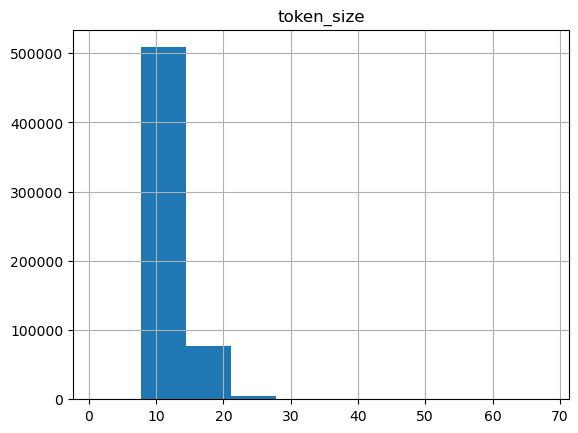

In [11]:
hist = captions_info_df.hist(['token_size'])

In [12]:
import h5py    
import numpy as np    

In [13]:
class COCO_CLIP_Dataset(Dataset):

    def __init__(
        self, caption_file, embedding_path, tokenizer, max_token_len_data):
        
        self.embedding_path = embedding_path
        self.caption_file = caption_file
        self.tokenizer = tokenizer
        self.max_token_len_data = max_token_len_data

    def __len__(self):
        return len(self.caption_file)
    
    def __getitem__(self, index):

        row = self.caption_file.iloc[[index]]

        df_img = row['image_id'].values[0]
        img_base_name = '0'*(12-len(str(df_img))) + str(df_img)
        img_base_name = img_base_name.replace(' ', '0')
        img_clip_embedding_path = os.path.join(self.embedding_path, f'{img_base_name}.h5')

        np_array_embed_img = h5py.File(img_clip_embedding_path,'r+')['image_features'][()]
        
        img_caption = row['caption'].values[0] ## Tokenize this 
        img_caption_tokenized = self.tokenizer(img_caption, return_tensors="pt", 
                                               return_attention_mask=False).input_ids

        ## put bos, eos, and padding for batch         
        # input_bos = torch.cat((torch.tensor(self.tokenizer.bos_token_id).view((1,1)), 
        #                                                img_caption_tokenized), dim=1)

        input_bos = img_caption_tokenized

        input_eos = torch.cat((input_bos, 
                               torch.tensor(self.tokenizer.eos_token_id).view((1,1))), dim=1)
        
        if (self.max_token_len_data - input_eos.shape[1]) > 0: 
            input_final =  torch.cat((input_eos,torch.tensor([self.tokenizer.pad_token_id]*(self.max_token_len_data - input_eos.shape[1])).unsqueeze(0)), dim=1)
        else: 
            input_final = input_eos
        
        return torch.tensor(np_array_embed_img).squeeze(0), input_final.squeeze(0)

In [14]:
def file_exists(image_id, fpath = '/media/App/amaranth/lavanya/Capstone_data/clip_features_base_patch32/'): 

    n = '0'*(12-len(str(image_id))) + str(image_id) + '.h5'
    fp = os.path.join(fpath, n)

    if os.path.exists(fp): 
        return True
    else: 
        return False

In [15]:
### captions_info_df contains for 1 image multiple entries, lets reduce keeping one image, one entry. 
captions_info_df_subset = captions_info_df.drop_duplicates(subset='image_id', keep='first')
captions_info_df_subset = captions_info_df_subset[captions_info_df_subset['token_size'] <=30]

In [16]:
max_token_len_data = 75
dataset = COCO_CLIP_Dataset(captions_info_df_subset, 
                            '/media/App/amaranth/lavanya/Capstone_data/clip_features_base_patch32/', 
                            tokenizer, max_token_len_data)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResBlock(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.pre_norm = nn.LayerNorm(input_size)
        self.proj = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.GELU(),
            nn.Linear(input_size, input_size)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)
    
class Phi2wrapper(nn.Module):
    
    #This defines the structure of the NN.
    def __init__(self, input_dim_CLIP=768, input_dim_phi2=2560, 
                 phi2_model=phi2_model_pretrained, 
                 max_token_len_data=max_token_len_data, tokenizer=tokenizer, teacher_forcing = 3, device=device):
        
        super(Phi2wrapper, self).__init__()

        self.input_dim_CLIP = input_dim_CLIP
        self.input_dim_phi2 = input_dim_phi2
        self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2, 
                                        bias=False)
                                                                                                                                                           
        self.resblock = SimpleResBlock(self.input_dim_phi2)
        self.phi2_model = phi2_model
        self.max_token_len_data = max_token_len_data
        self.tokenizer = tokenizer

        self.device = device
        self.teacher_forcing = teacher_forcing

        bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
        eoi = self.tokenizer(" Caption: ", return_tensors="pt", return_attention_mask=False)
    
        self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
        self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)
        self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

    def forward(self, x, input_caption):

        x = self.projection_img(x)
        x = self.resblock(x)

        batch_size = x.shape[0]

        x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x, 
                    self.eoi_embedding.repeat(batch_size,1,1)), dim=1)
        
        loss = 0 
        word_output_pred_tokens = None

        for idx in range(input_caption.shape[1]): 
            
            out_phi = self.phi2_model.model.layers[0](x.to(torch.float16))
            
            for layer_idx in range(1, 32): 
                out_phi = self.phi2_model.model.layers[layer_idx](out_phi[0])
                
            out_phi = self.phi2_model.model.final_layernorm(out_phi[0])
            out_phi = self.phi2_model.lm_head(zzout_phi) ## torch.Size([batch, 55, 50297])
            
            next_word = torch.argmax(out_phi[:, -1, :], dim=-1) ## [batch]
            
            caption_word_token = input_caption[:,idx]
            
#             print("Decode:", self.tokenizer.decode(next_word))
#             print("Decode gt:", self.tokenizer.decode(caption_word_token))
            
            no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device), caption_word_token))
            
            if no_of_pad_tokens == torch.tensor(batch_size): 
                break 
                
            if idx>=self.teacher_forcing:
#                 print(idx, " next word model", self.tokenizer.decode(next_word))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(next_word).unsqueeze(1)
            else:
#                 print(idx, " next word ground truth", self.tokenizer.decode(caption_word_token))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)
            
            ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
            x = torch.cat((x, caption_word_embedding), dim=1)
            
            loss_val = F.cross_entropy(out_phi[:, -1, :], caption_word_token, 
                        ignore_index=self.tokenizer.pad_token_id)
            
            loss += loss_val
            
            if word_output_pred_tokens is None: 
                word_output_pred_tokens = next_word.unsqueeze(1) 
            else:

                word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.unsqueeze(1)), dim=1)
        
        return loss/idx, word_output_pred_tokens


torch.set_grad_enabled(True)  
phi2_projection_model = Phi2wrapper().to(device=device)

## Freezing phi-2 for projection layer training 
for name, param in phi2_projection_model.named_parameters():
    if "phi2_model" in name:
        param.requires_grad = False
    else: 
        param.requires_grad = True

In [18]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class SimpleResBlock(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.pre_norm = nn.LayerNorm(input_size)
#         self.proj = nn.Sequential(
#             nn.Linear(input_size, input_size),
#             nn.GELU(),
#             nn.Linear(input_size, input_size)
#         )
#     def forward(self, x):
#         x = self.pre_norm(x)
#         return x + self.proj(x)
    
# class Phi2wrapper(nn.Module):
    
#     #This defines the structure of the NN.
#     def __init__(self, input_dim_CLIP=768, input_dim_phi2=2560, 
#                  phi2_model=phi2_model_pretrained, 
#                  max_token_len_data=max_token_len_data, tokenizer=tokenizer, device=device):
        
#         super(Phi2wrapper, self).__init__()

#         self.input_dim_CLIP = input_dim_CLIP
#         self.input_dim_phi2 = input_dim_phi2
#         self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2, 
#                                         bias=False)
        
# #         1, 49, 2560 
# #         1, 75, 2560 <-- embedding of Image (training) x the model predict (CLIP)
        
# #         caption_tkens = tokenizer(caption, return_tensors="pt", return_attention_mask=False)
# #         caption_gt_embediing = phi2_model.get_input_embeddings()(torch.tensor(caption_tokens).to(self
# #         1, 75, 2560 <-- output y 
                                                                                                                                                                                       
#         self.resblock = SimpleResBlock(self.input_dim_phi2)
#         self.phi2_model = phi2_model
#         self.max_token_len_data = max_token_len_data
#         self.tokenizer = tokenizer

#         self.device = device

#         bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
#         eoi = self.tokenizer(" Caption: ", return_tensors="pt", return_attention_mask=False)
    
#         self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
#         self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)
#         self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

#     def forward(self, x, input_caption):

#         x = self.projection_img(x)
#         x = self.resblock(x)

#         batch_size = x.shape[0]

# #         imgae_prompt_embed = x.clone()
#         x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x, 
#                     self.eoi_embedding.repeat(batch_size,1,1)), dim=1)
        
#         loss = 0 
#         word_output_pred_tokens = None

#         for idx in range(input_caption.shape[1]): 
            
# #             next_word = self.phi2_model.forward(inputs_embeds=x.to(torch.float16))["logits"][:, -1, :]
            
#             next_word = self.phi2_model.generate(inputs_embeds=x.to(torch.float16), max_new_tokens = 1, 
#                                             output_scores=True, return_dict_in_generate = True, 
#                                             pad_token_id=self.tokenizer.pad_token_id, 
#                                             bos_token_id=self.tokenizer.bos_token_id, 
#                                             eos_token_id=self.tokenizer.eos_token_id) ## this gives first word  
                        
#             caption_word_token = input_caption[:,idx]
            
#             no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device), caption_word_token))
#             if no_of_pad_tokens == torch.tensor(batch_size): 
#                 break 
            
#             caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)
            
#             ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
#             x = torch.cat((x, caption_word_embedding), dim=1)

# #             caption_word_token_new = input_caption[:, :idx+1]
# #             caption_word_embedding_new = self.phi2_model.get_input_embeddings()(caption_word_token_new)
# #             x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), imgae_prompt_embed, caption_word_embedding_new,  
# #                     self.eoi_embedding.repeat(batch_size,1,1)), dim=1)

# #             loss_val = F.cross_entropy(F.softmax(next_word, dim=-1), caption_word_token, 
# #                         ignore_index=self.tokenizer.pad_token_id, label_smoothing=0.1)

#             loss_val = F.cross_entropy(next_word.scores[0], caption_word_token, 
#                         ignore_index=self.tokenizer.pad_token_id, label_smoothing=0.1)

#             loss += loss_val
            
# #             if word_output_pred_tokens is None: 
# #                 word_output_pred_tokens = torch.argmax(next_word,dim=-1).unsqueeze(1) 
# #             else:

# #                 word_output_pred_tokens = torch.cat((word_output_pred_tokens, torch.argmax(next_word,dim=-1).unsqueeze(1)), dim=1)
    
#             if word_output_pred_tokens is None:
#                 word_output_pred_tokens = next_word.sequences[:, 1].unsqueeze(1)
#             else:
#                 word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.sequences[:, 1].unsqueeze(1)), dim=1)
    
#         loss_tosend = loss/idx

#         return loss_tosend, word_output_pred_tokens

#         ### Without feature forcing
#         # x = self.phi2_model.generate(inputs_embeds=x, 
#         #                              max_new_tokens=self.max_token_len_data, 
#         #                              output_scores=True, return_dict_in_generate = True, 
#         #                              pad_token_id=self.tokenizer.eos_token_id, 
#         #                              bos_token_id=self.tokenizer.bos_token_id, 
#         #                              eos_token_id=self.tokenizer.eos_token_id)

#         # return x 

# torch.set_grad_enabled(True)  
# phi2_projection_model = Phi2wrapper().to(device=device)

# ## Freezing phi-2 for projection layer training 
# for name, param in phi2_projection_model.named_parameters():
#     if "phi2_model" in name:
#         param.requires_grad = False
#     else: 
#         param.requires_grad = True

In [19]:
batch_size_train = 2
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True, num_workers=8)

num_batches_train_on = 30000
num_batches_train_on, len(train_dataloader)

(30000, 59088)

In [20]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, 
                                    phi2_projection_model.parameters()), 
                            lr=1e-5, eps=1e-9) 

In [ ]:
num_epochs = 10
vocab_size = len(tokenizer)

phi2_projection_model.train()
N_batches = len(train_dataloader)
                
for epoch in range(num_epochs):

    print(f"Working on epoch {epoch}")

    for iteration, batch in enumerate(train_dataloader):

#         if iteration == num_batches_train_on: 
#             break 

        optimizer.zero_grad()

        input_ = batch[0]
        gt = batch[1] 

        loss, output_pred_tokens = phi2_projection_model(input_.to(device), gt.to(device))

#         loss.requires_grad = True ## use with geenrate 
        loss.backward(retain_graph=True)

        optimizer.step()

        if (iteration % 100) == 0: 
            print("Loss:", loss)
            print("Iteration:", iteration)
            print("Predictions:", tokenizer.batch_decode(output_pred_tokens)[0].rstrip())
            print("Gt:", tokenizer.batch_decode(gt)[0].split('<|endoftext|>')[0])

    print("")
    print(f"Epoch {epoch} finished")
    print("")

Working on epoch 0
Loss: tensor(7.9258, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 0
Predictions: 
. with a few of the most of the
Gt: A room with a couch and a tv monitor 
Loss: tensor(5.6641, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 100
Predictions: A man with a a. a. a.
Gt: A man holding a glass of white wine.
Loss: tensor(5.2422, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 200
Predictions: A man bat in a a. a. a.
Gt: A baseball player with a dirty uniform running to a base
Loss: tensor(5.5195, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 300
Predictions: A man man player in a net.... a
Gt: A professional tennis player with an orange shirt and grey shorts.
Loss: tensor(5.7734, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 400
Predictions: A man sitting on a a.......
Gt: A person hiking up the side of a snow covered hillside.
Loss: tensor(5

Loss: tensor(4.5898, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4200
Predictions: A plate with on a a plate......
Gt: A pizza sitting on top of a wooden cutting board.
Loss: tensor(4.2969, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4300
Predictions: A baby girl playing with a toy...
Gt: a little kid is brushing his teeth and smiling
Loss: tensor(5.1016, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4400
Predictions: Aicy flying over a a a beach..........
Gt: Birds flying over a sandy beach and landing on a platform.
Loss: tensor(4.0078, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4500
Predictions: A man man a on a a a. a......
Gt: a black train with a red car and three people next to it
Loss: tensor(3.9727, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4600
Predictions: A man bus bus with a on a.....
Gt: A yellow school bus parked in a parking l

Loss: tensor(4.8945, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8300
Predictions: A large of cows in a a a a a......
Gt: A group of cows grazing in trash next to wall.
Loss: tensor(2.9121, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8400
Predictions: A man of people playing baseball in a a a..
Gt: A couple of people playing a game of frisbee.
Loss: tensor(4.5352, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8500
Predictions: A man riding a motorcycle on a a street a.........
Gt: A man riding on the back of a motorcycle while towing a man on a skateboard.
Loss: tensor(4.2344, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8600
Predictions: A man is standing on a a a a....
Gt: A man is standing next to a tree with a surfboard.
Loss: tensor(7.5664, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8700
Predictions: A red sign with a a a a. a...
Gt: A whit

Loss: tensor(3.1680, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12300
Predictions: A bottle of bottles and on a a a..
Gt: a group of bottles and cans on a refrigerator shelf.
Loss: tensor(6.1172, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12400
Predictions: A person is flying a over a a a....
Gt: a man is out parasailing at the beach
Loss: tensor(3.1270, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12500
Predictions: A group of children playing on a a a..
Gt: A group of children standing around a woman.
Loss: tensor(4.5664, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12600
Predictions: A red sign on a street a. street
Gt: a street sign sits on a cement ball 
Loss: tensor(4.4023, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12700
Predictions: A dogs are in a a a a grass...
Gt: Two dogs playing Frisbee in an open field.
Loss: tensor(4.7891, devi

Loss: tensor(5.3320, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16400
Predictions: A group beach with a a a flying a......
Gt: A sandy beach next to the ocean under a sky filled with kites.
Loss: tensor(3.6348, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16500
Predictions: A man playing on a a a a a a..
Gt: A man sitting at a park working on a laptop computer.
Loss: tensor(3.1699, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16600
Predictions: A laptop sitting a on a a a....
Gt: A laptop and some computers on a desk.
Loss: tensor(4.1406, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16700
Predictions: A stop of red and a a a a a a....
Gt: a couple of street signs on a pole outside
Loss: tensor(4.3320, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16800
Predictions: A group and woman holding a a a a...
Gt: A man and a little girl holding game contr

Loss: tensor(4.8477, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20400
Predictions: A bathroom with in a a a a.......
Gt: A sink sitting under a large bathroom mirror.
Loss: tensor(4.2773, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20500
Predictions: A man is a motorcycle a a a a.....
Gt: A man riding a motorcycle with a large dog on back of it.
Loss: tensor(3.4277, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20600
Predictions: A cat sitting on top of a a a......
Gt: A cat laying by a banister on top of a red suitcase.
Loss: tensor(3.3359, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20700
Predictions: A man is walking down a a a a a..
Gt: A man is walking out of a pizza restaurant with his pizza
Loss: tensor(2.7949, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20800
Predictions: A red bus white bus parked a a a....
Gt: A red and black bus park

In [ ]:
'''
TODO: 1. Tensorboard, 
2. Flash attention, 
3. Phi2 (float16), 
4.model.forwrd?, 
5.eos_token to inputprompt, 
6.Onecycle policy
7.Smaller lr?''' 